# KI - Projekt: Evidenztheorie

Anhand von Sensor-Daten soll kassifiziert werden, ob es sich bei dem vermessenen Objekt um einen PKW, einen LKW, ein Motorrad oder ein Fahrrad handelt.
<br>
Folgende Kategorien werden unterschieden: <br>

| <b>KFZ-Art<b> | <b>Geschwindigkeit</b> | <b>Beschleunigung</b>| <b>Höhe</b> | <b>Breite</b> |
| --------------|------------------------|----------------------|-------------|-------------- |
| <b>Fahrrad</b> | Langsam | - | hoch | schmal |
| <b>PKW</b> | Mittel | - | flach | breit |
| <b>LKW</b> | Mittel | Schwach | hoch | breit |
| <b>Motorrad</b> | Mittel | Stark | hoch | schmal |

- Mittlere Geschwindigkeit zwischen 50 und 90 km/h.

## Schritte / Methoden:
1. Daten einlesen, explorieren + neue Datensätze berechnen.
2. Grenzwerte für 'hoch', 'flach', 'starke Beschleunigung', ... berechnen.
3. Einzelne Datensequenzen einlesen und Fahrzeugart mithilfe von `python_evidence`-Framework bestimmen.
  1. Werte (Geschw., Beschl., ...) bestimmen.
  2. Evidenz-Messungen (+ Wahrscheinlichkeiten) festlegen.
  3. Fahrzeugart bestimmen.

## Hinweis
- Sensoren arbeiten auf hohen Entfernungen ungenauer:
  - Mögliche Fehlerquelle, möglicherweise korrigieren / einberechnen.

In [7]:
# Imports
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from python_evidence.dempster_handler import DempsterHandler, Measure
from utils import load_data, change_data, get_velocity, get_acceleration, save_data_dict, get_dimensions
from utils import get_max_range_by_criterion, get_acceleration_limit, calculate_weighted_ratio

# Daten einlesen und explorieren

--------------------------------------------------

Daten befinden sich in Form von CSV Dateien im [data](/data)-Ordner.

Sie bestehen aus jeweils einzelnen Mess-Sequenzen für ein Fahrzeug. Die Messdaten bestehen aus:
- t
  - Zeitpunkte (Messung alle 100ms)
- Eigengeschwindigkeit(m/s)
- Bbox_Breite
- Bbox_Höhe
- Bbox_links_unten_y
- Abstand(m)

In [8]:
# Location of CSV files
DATA_FOLDER = Path("data")
CSV_FILES = ["DPE15_1.csv", "DPE15_2.csv", "DPE15_3.csv", "DPE15_4.csv", 
             "DPE16_1.csv", "DPE16_2.csv", "DPE16_3.csv", "DPE16_4.csv"]

for ix, path in enumerate(CSV_FILES):
    CSV_FILES[ix] = DATA_FOLDER.joinpath(path)

# Load CSV file data.
data_dict = load_data(CSV_FILES)

"""
Explore data.
"""
df = data_dict["DPE15_1"]
display(df)

print(df.info())


,t,Eigengeschwindigkeit(m/s),Bbox_Breite,Bbox_Höhe,Bbox_links_unten_y,Abstand(m)
0,0,"16,1",61,121,142,71
1,"0,1","16,1",64,128,141,"70,5"
2,"0,2",16,64,127,138,69
3,"0,3","16,1",66,131,138,69
4,"0,4",16,67,134,137,"68,5"
...,...,...,...,...,...,...
99,"9,9","16,1",181,362,22,11
100,10,"16,2",183,366,20,10
101,"10,1","16,1",183,365,18,9
102,"10,2","16,1",230,374,18,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   t                          104 non-null    object
 1   Eigengeschwindigkeit(m/s)  104 non-null    object
 2   Bbox_Breite                104 non-null    int64 
 3   Bbox_Höhe                  104 non-null    int64 
 4   Bbox_links_unten_y         104 non-null    int64 
 5   Abstand(m)                 104 non-null    object
dtypes: int64(3), object(3)
memory usage: 5.0+ KB
None


# Neue Datensätz berechnen / Daten updaten.

-------------------------------------

* Anpassen der Datentypen.
* Berechnung von weiteren Daten:
  * Geschwindigkeit des anderen Fahrzeugs.
  * Dimensionen des anderen Fahrzeugs.



In [9]:
"""
* Eigengeschwindigkeit(m/s) to floats
* Convert velocity from m/s to km/h
* Abstand(m) to floats
* Timestamps to floats
* Calculate velocity and dimensions.
"""
change_data(data_dict)
MODELS = {}

# Calculate velocity and dimensions.
for path, df in data_dict.items():
    velocity_model, distance_model = get_velocity(df)
    MODELS.update({path: {"Velocity Model": velocity_model, "Distance Model": distance_model}})
    get_dimensions(df)

# Look at calculated / updated data.
print(data_dict["DPE16_2"].info())
display(data_dict["DPE16_2"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   t                          104 non-null    float64
 1   Eigengeschwindigkeit(m/s)  104 non-null    float64
 2   Bbox_Breite                104 non-null    int64  
 3   Bbox_Höhe                  104 non-null    int64  
 4   Bbox_links_unten_y         104 non-null    int64  
 5   Abstand(m)                 104 non-null    float64
 6   v(km/h)                    104 non-null    float64
 7   width                      104 non-null    float64
 8   height                     104 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 7.4 KB
None


,t,Eigengeschwindigkeit(m/s),Bbox_Breite,Bbox_Höhe,Bbox_links_unten_y,Abstand(m),v(km/h),width,height
0,0.0,22.0,304,226,87,43.5,73.908889,1.955,1.565
1,0.1,22.1,276,227,87,43.5,74.444299,1.815,1.570
2,0.2,22.1,279,230,87,43.5,74.974724,1.830,1.585
3,0.3,22.0,287,236,86,43.0,75.500163,1.865,1.610
4,0.4,22.2,283,233,86,43.0,76.020618,1.845,1.595
...,...,...,...,...,...,...,...,...,...
99,9.9,22.0,106,87,157,78.5,102.730354,1.315,1.220
100,10.0,22.1,104,85,159,79.5,102.772210,1.315,1.220
101,10.1,22.0,126,77,162,81.0,102.809081,1.440,1.195
102,10.2,22.1,101,83,161,80.5,102.840966,1.310,1.220


## Geschwindigkeit & Beschleunigung

Aufgrund von enormen Schwankung bei den direkt vermessenen Daten (siehe Plots), wird folgende Methodik verwendet:
1. Ploynomiale Regression über die Messdaten. Ziel: 'Mittlung' der Messdaten macht Messfehler / Schwankungen transparent.
2. Ableitung des errechneten Geschwindigkeits-Modells liefert die Beschleunigung.

Alle errechneten Daten / Regressionen jedes Datensatz werden geplottet.

## Erkenntnisse

* Die polynomiale Regression hat teilweise an den Grenzen der Zeitachse enorme Steigungen (vgl DPE16_4).
  * Eine mögliche Lösung dieses 'Problems' wäre das Abschneiden der Enden.


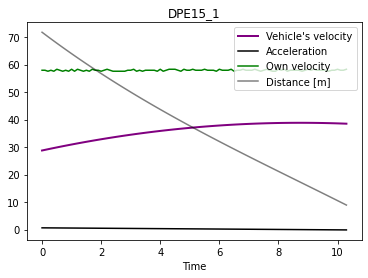

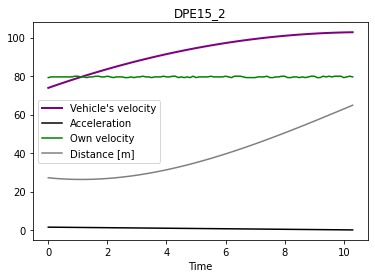

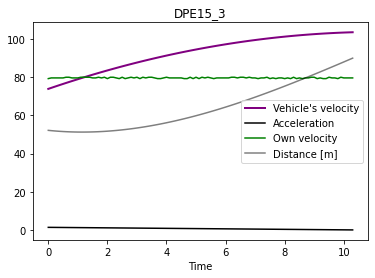

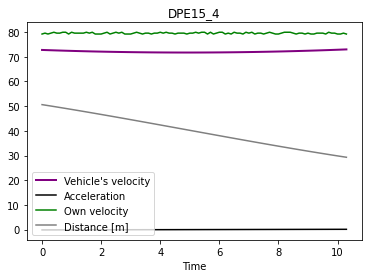

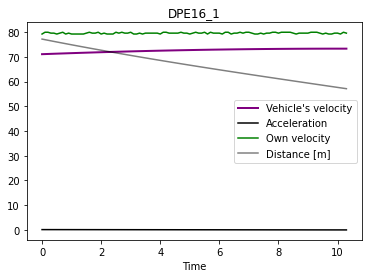

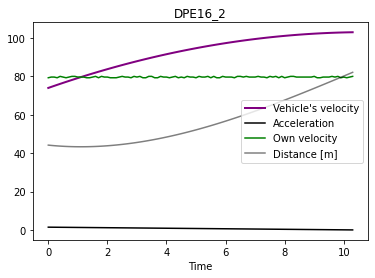

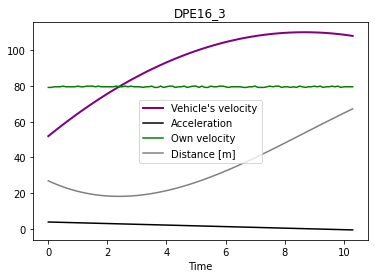

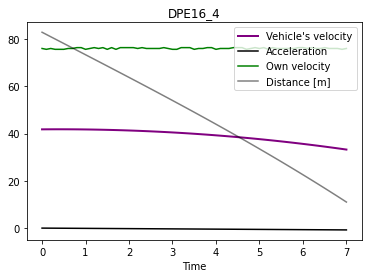

In [15]:
# plot calculated velocity and acceleration
for path, df in data_dict.items():
    plt.title(path)
    plt.xlabel("Time")
    velocity_key = "v(km/h)"

    # Plot optimized velocity
    plt.plot(df["t"], df[velocity_key], linewidth=2, color="purple", label="Vehicle's velocity")

    # Call method which extends data frame by the acceleration
    get_acceleration(df, MODELS[path]["Velocity Model"])

    # Plot acceleration
    plt.plot(df["t"], df["a(km/h^2)"], color="black", label="Acceleration")

    # Plot the velocity of the data recording vehicle
    plt.plot(df["t"], df["Eigengeschwindigkeit(m/s)"]  * 3.6, color="green", label="Own velocity")
    
    # Plot the distances.
    plt.plot(df["t"], MODELS[path]["Distance Model"](df["t"]), color="black", alpha=0.5, label="Distance [m]")
    
    plt.legend()
    plt.show()

# Save data in dictionary for further calculations
save_data_dict(data_dict, Path("updated_data"))

## Wichtige Daten herausfinden

Einige Daten / Grenzwerte sind interessant für die spätere Auswertung:
* Maximal und minimal Geschwindigkeiten.
* Maximal und minimal Beschleunigungen.
* Verhältnis von Höhe und Breite.

DPE15_1
_______________________________________
Velocity:     min: 28.77359676886199   max: 38.84589351002987
Acceleration: min: -0.11524277440190445  max: 0.6409605509089926
Height : Width ratio 1.6586129519601869


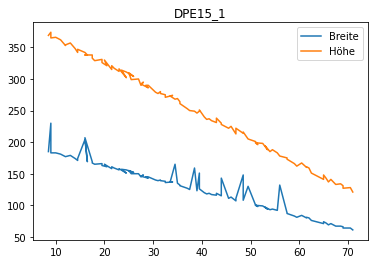

DPE15_2
_______________________________________
Velocity:     min: 73.85341463778441   max: 102.762008263914
Acceleration: min: 0.06266488337831189  max: 1.4965904362619034
Height : Width ratio 1.183005872816362


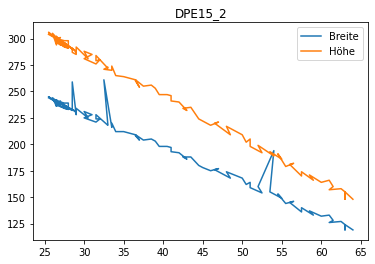

DPE15_3
_______________________________________
Velocity:     min: 73.83432149409211   max: 103.43253349297005
Acceleration: min: 0.12743402082930544  max: 1.4690175432957178
Height : Width ratio 0.8871022371523548


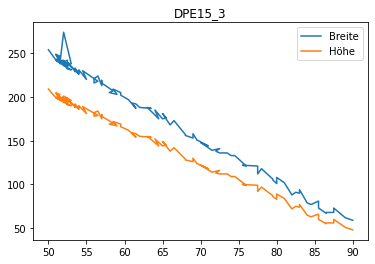

DPE15_4
_______________________________________
Velocity:     min: 71.70615205020523   max: 72.9733101475246
Acceleration: min: -0.1186881410341637  max: 0.13050568245743166
Height : Width ratio 1.527990785003668


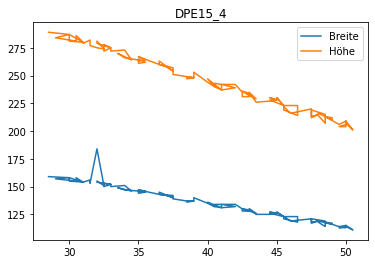

DPE16_1
_______________________________________
Velocity:     min: 71.04905015738001   max: 73.28457965863787
Acceleration: min: -0.0024250778824985997  max: 0.12295689566548687
Height : Width ratio 1.0465914918319794


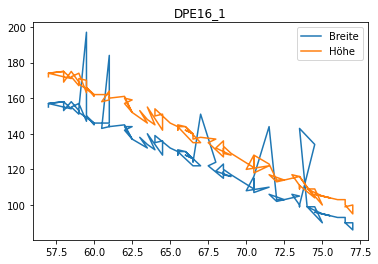

DPE16_2
_______________________________________
Velocity:     min: 73.9088887500162   max: 102.86786595483129
Acceleration: min: 0.06779788546260113  max: 1.4941749950560148
Height : Width ratio 0.8709995931914623


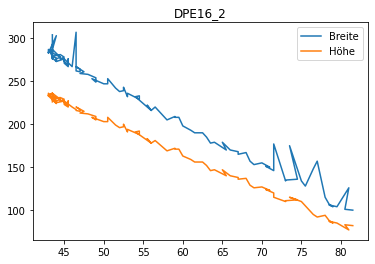

DPE16_3
_______________________________________
Velocity:     min: 51.867641071303815   max: 110.13861507291014
Acceleration: min: -0.7022315536643289  max: 3.734099957880602
Height : Width ratio 1.0222980425917882


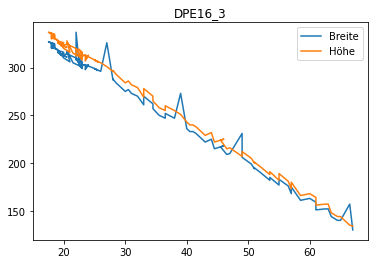

DPE16_4
_______________________________________
Velocity:     min: 33.24040519338445   max: 41.811404898806984
Acceleration: min: -0.7204614346889946  max: 0.04260034318462002
Height : Width ratio 1.5767515317746466


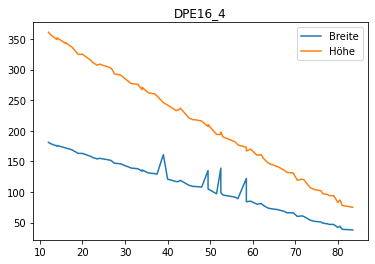

In [11]:
for path, df in data_dict.items():
    # Plot the measured with and height over the distance.
    plt.title(path)
    plt.plot(df["Abstand(m)"], df["Bbox_Breite"], label="Breite")
    plt.plot(df["Abstand(m)"], df["Bbox_Höhe"], label="Höhe")
   
    print(path)
    print("_______________________________________")
    
    # Print min and max of velocity / acceleration.
    print("Velocity:     min:", df["v(km/h)"].min(), "  max:", df["v(km/h)"].max())
    print("Acceleration: min:", df["a(km/h^2)"].min(), " max:", df["a(km/h^2)"].max())
    
    # Print height to width ratios
    height_width_ratio = calculate_weighted_ratio(df["height"], df["width"], df["Abstand(m)"])
    print("Height : Width ratio", height_width_ratio)
    
    plt.legend()
    plt.show()

# Evidenzen

* Berechnen einiger Limits.
* evidenz-Messungen festlegen anhand von gemessenen Daten.
* Ergebnisse plotten.

Velocity is lower 50 km/h
Low acceleration
High and narrow
Correcting with  1.5384615384615383


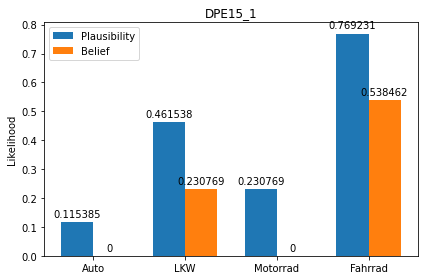

Velocity is greater 50 km/h
High acceleration
High and narrow


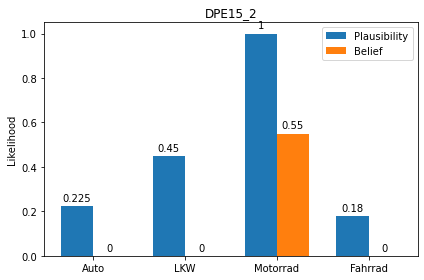

Velocity is greater 50 km/h
High acceleration
flat and wide
Correcting with  1.6260162601626016


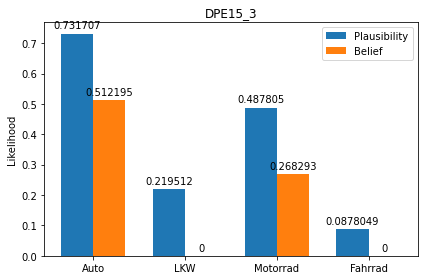

Velocity is greater 50 km/h
Low acceleration
High and narrow


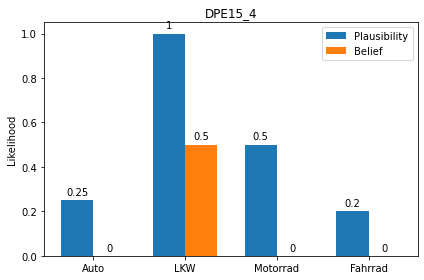

Velocity is greater 50 km/h
Low acceleration
High and narrow


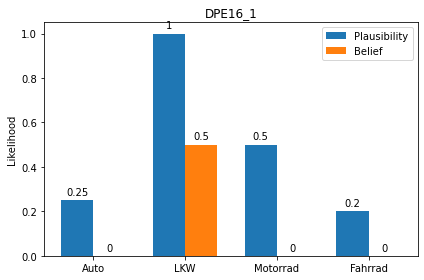

Velocity is greater 50 km/h
High acceleration
flat and wide
Correcting with  1.6260162601626016


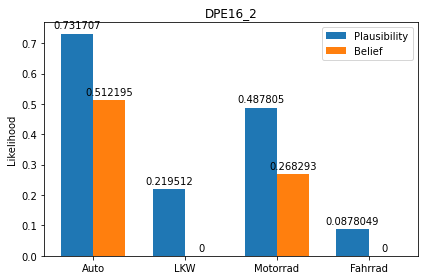

Velocity is greater 50 km/h
High acceleration
High and narrow


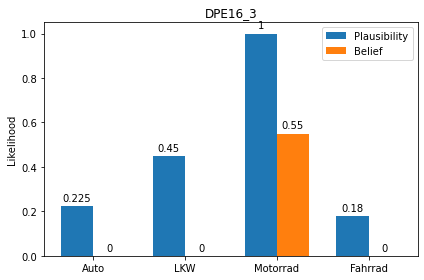

Velocity is lower 50 km/h
Low acceleration
High and narrow
Correcting with  1.5384615384615383


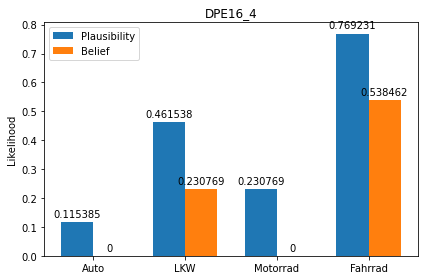

In [12]:
# Get dynamic acceleration limits
ACCELERATION_LIMIT_UPPER = get_acceleration_limit(data_dict, limit=0.9)
ACCELERATION_LIMIT_LOWER =  get_acceleration_limit(data_dict, limit=0.1)

# Estimate the category of the measured vehicle
def estimate_vehicle_type(df, title):
    """ estimate type of vehicle, based on bounding box, speed and acceleration"""
    handler = DempsterHandler(["Auto", "LKW", "Motorrad", "Fahrrad"])

    # Check type of vehicle on basis of its velocity
    # At a speed greater than 50 it is unlikely to deal with a bicycle
    range_speed_greater_50 = get_max_range_by_criterion(df["v(km/h)"], lambda x : x >= 50)
    if range_speed_greater_50 >= 10:
        print("Velocity is greater 50 km/h")
        handler.add_measure([
            Measure(["Auto", "LKW", "Motorrad"], 0.6)
        ])
    else:
        print("Velocity is lower 50 km/h")
        handler.add_measure([
            Measure(["Fahrrad"], 0.7)
        ])

    # Check type of vehicle on basis of its acceleration
    # A high acceleration could indicate a motorcycle
    if get_max_range_by_criterion(df["a(km/h^2)"],
                                 lambda x : abs(x) >= ACCELERATION_LIMIT_UPPER) >= 5:
        print("High acceleration")
        handler.add_measure([
            Measure(["Motorrad"], 0.55)
        ])
    elif get_max_range_by_criterion(df["a(km/h^2)"],
                                   lambda x : abs(x) <= ACCELERATION_LIMIT_LOWER) >= 5:
        print("Low acceleration")
        handler.add_measure([
            Measure(["LKW"], 0.5)
        ])

    # Check height to width ratio
    # A ratio >= 1 (taller than wide) could indicate a Motorrad, Fahrrad or LKW
    height_width_ratio = calculate_weighted_ratio(df["height"], df["width"], df["Abstand(m)"])
    if height_width_ratio >= 1.0:
        print("High and narrow")
        handler.add_measure([
            Measure(["Motorrad", "Fahrrad", "LKW"], 0.5)
        ])
    else:
        print("flat and wide")
        handler.add_measure([
            Measure(["Auto"], 0.7)
        ])
    
    # Accumulate measures and calculate plausibilities and beliefs
    accumulate = handler.accumulate()
    pls = []
    blfs = []
    categories = handler.categories()
    for category in categories:
        p = handler.plausibility(accumulate, category)
        b = handler.belief(accumulate, category)
        pls.append(p)
        blfs.append(b)
       
    # Plot plausibilities and beliefs
    width = 0.35
    x = np.arange(len(categories))
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, pls, width, label="Plausibility")
    rects2 = ax.bar(x + width/2, blfs, width, label="Belief")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Likelihood")
    ax.set_title(title)
    ax.set_xticks(x, categories)
    ax.legend()
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    fig.tight_layout()

    plt.savefig(F"pics/{title}.png")
    plt.show()

# Estimate types for all sensor datas.
for name, df in data_dict.items():
    estimate_vehicle_type(df, name)